# How to use a FIGARO reconstruction

FIGARO, despite being a stochastic sampler, does not produce a set of samples (numbers) directly, but rather a number of `figaro.mixture.mixture` objects stored as `.json` or `.pkl` files. Each of these objects represents a probability density drawn around the probability density that generated the available data. If you need to use these realisations in a `python` script (to evaluate their pdf, for example, or to draw realisations from them), here you'll find the (few!) steps needed for doing so.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from figaro import plot_settings
%matplotlib inline

## Basic usage 

Let us assume to have our realisations stored in a file called `draws_file.json` (they can be the product of a hierarchical inference or a DPGMM reconstruction, it does not make any difference). The first thing to do is to load the realisations via the dedicated method, `figaro.load.load_density`:

In [2]:
from figaro.load import load_density
draws = load_density('./draws_example.json')

`draws` will be a list of `figaro.mixture.mixture` objects, each of them representing a probability distribution. The methods of this class are modelled after the `scipy.stats` methods to facilitate users that are already familiar with the SciPy package:

In [3]:
d = draws[0]
X = 2.
(d.pdf(X), d.logpdf(X), d.cdf(X), d.rvs(3))

(array([0.03470811]),
 array([-3.36078192]),
 array([0.98599125]),
 array([[-0.214056  ],
        [ 0.09627442],
        [-1.66075543]]))

## Advanced use

If you need to draw samples from the median distribution, there is a dedicated method in the `figaro.utils` module:

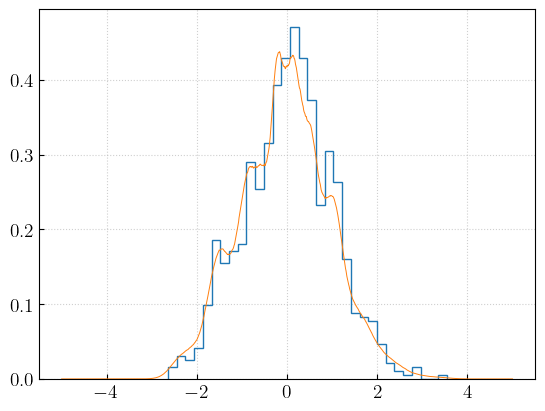

In [4]:
from figaro.utils import rvs_median

x = np.linspace(*draws[0].bounds[0], 1000)
med = np.median([d.pdf(x) for d in draws], axis = 0)

samples = rvs_median(draws, size = 1000)

fig, ax = plt.subplots()
_ = ax.hist(samples, histtype = 'step', density = True)
_ = ax.plot(x, med)

The gradient of the recovered distribution can be evaluated using the `gradient()` method of individual draws:

In [5]:
d.gradient(X)

array([[-0.12637676]])

It is also possible to evaluate the gradient of the median distribution in a numerically stable way using the dedicated function:

In [6]:
from figaro.utils import gradient_median
gradient_median(X, draws)

array([[-0.09038139]])

Please note: these methods are painfully slow and we haven't really found a way of optimising them. If you manage to improve it, please open a pull request!

For multivariate distributions, it might happen that one needs to evaluate the conditional distribution or the marginal distribution.
Making use of the properties of the multivariate Gaussian distribution, we can obtain the conditional and/or marginal distribution analytically both via the methods included in the `figaro.mixture.mixture` class or via the ones in the `figaro.marginal` module:

In [7]:
draws = load_density('./draws_example_2d.json')

d = draws[0]

# Single draw
d_marg = d.marginalise([1]) # Marginalisation over the second dimension
d_cond = d.condition([1.2], [0]) # Condition on a specific value along the first dimension

from figaro.marginal import marginalise, condition

# Vectorised
draws_marg = marginalise(draws, [1])
draws_cond = condition(draws,[1.2], [0])

Please note that in both cases the original `draws` are preserved.

A set of reconstructions can be saved using the `figaro.load.save_density` method:

In [8]:
from figaro.load import save_density

save_density(draws_marg, folder = '.', name = 'marginalised')

## Plots

The plots produced by the CLI can be easily reproduced using the methods included in the `figaro.plot` module, mainly `figaro.plot.plot_median_cr` and `figaro.plot.plot_multidim`. Please refer to the relevant documentation page for the details. 